In [29]:
from gerrychain import Graph 

In [30]:
# Read New Mexico county graph from the json file "NM_county.json"
filepath = '\\Users\\colle\\Downloads\\'
filename = 'NM_county.json'

G = Graph.from_json( filepath + filename )

In [31]:
for node in G.nodes:
    county_name = G.nodes[node]['NAME20']
    county_population = G.nodes[node]['P0010001']
    G.nodes[node]['TOTPOP'] = county_population
    #print('Node', node, 'represents', county_name, 'County, which had a population of', county_population, 'in the 2020 census.')

In [32]:
# Let's impose a 1% population deviation (+/-0.5%)
deviation = 0.01

import math
k = 3          # number of districts
total_population = sum( G.nodes[node]['TOTPOP'] for node in G.nodes )
ideal_population = total_population / k

L = math.ceil( ( 1 - deviation / 2 ) * ideal_population )
U = math.floor( ( 1 + deviation / 2 ) * ideal_population )
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 702312 and U = 709369 and k = 3


In [33]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)    # y[u,v] equals one when edge {u,v} is cut

In [34]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

#m.setObjective (gp.quicksum( y ), GRB.MINIMIZE)

In [35]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {u,v} is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))

m.update()

In [36]:
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 273 rows, 177 columns and 999 nonzeros
Model fingerprint: 0xb8107d26
Variable types: 0 continuous, 177 integer (177 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]
Found heuristic solution: objective 49.0000000
Presolve time: 0.00s
Presolved: 273 rows, 177 columns, 999 nonzeros
Variable types: 0 continuous, 177 integer (177 binary)

Root relaxation: objective 0.000000e+00, 132 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0   99   49.00000    0.00000   10

In [37]:
# Now, let's add contiguity constraints and re-solve the model.
# We will use the contiguity constraints of Hojny et al. (MPC, 2021)
#   https://link.springer.com/article/10.1007/s12532-020-00186-3

# Add root variables: r[i,j] equals 1 if node i is the "root" of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY )

# Add flow variables: f[u,v] = amount of flow sent across arc uv 
#  Flows are sent across arcs of the directed version of G which we call DG

import networkx as nx
DG = nx.DiGraph(G)      # directed version of G

f = m.addVars( DG.edges )

In [38]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1

# Each district j should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )

# If node i is not assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) ) 

# if not a root, consume some flow.
# if a root, only send out (so much) flow.
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )

# do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * ( 1 - y[i,j] ) for i,j in G.edges )

m.update()

In [39]:
# solve IP model
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 486 rows, 432 columns and 1941 nonzeros
Model fingerprint: 0x4d991e6b
Variable types: 156 continuous, 276 integer (276 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]

MIP start from previous solve did not produce a new incumbent solution

Presolve time: 0.01s
Presolved: 486 rows, 432 columns, 1950 nonzeros
Variable types: 156 continuous, 276 integer (276 binary)

Root relaxation: objective 0.000000e+00, 188 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0

In [40]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 19.0
District 0 has population 708853 and contains counties ['Curry', 'Roosevelt', 'Lincoln', 'Guadalupe', 'Luna', 'Lea', 'Chaves', 'Quay', 'Sierra', 'De Baca', 'Otero', 'Catron', 'San Miguel', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']

District 1 has population 703616 and contains counties ['Bernalillo', 'Cibola']

District 2 has population 705053 and contains counties ['San Juan', 'Torrance', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Valencia', 'Union', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']



In [42]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 19.0
District 0 has population 708853 and contains counties ['Curry', 'Roosevelt', 'Lincoln', 'Guadalupe', 'Luna', 'Lea', 'Chaves', 'Quay', 'Sierra', 'De Baca', 'Otero', 'Catron', 'San Miguel', 'Grant', 'Doña Ana', 'Hidalgo', 'Socorro', 'Eddy']

District 1 has population 703616 and contains counties ['Bernalillo', 'Cibola']

District 2 has population 705053 and contains counties ['San Juan', 'Torrance', 'McKinley', 'Rio Arriba', 'Santa Fe', 'Valencia', 'Union', 'Taos', 'Colfax', 'Sandoval', 'Harding', 'Los Alamos', 'Mora']



In [43]:
import networkx as nx
for district in districts:
    print('Is district =', district, 'connected', nx.is_connected(G.subgraph(district)))

Is district = [0, 1, 3, 4, 6, 9, 10, 12, 14, 16, 17, 18, 20, 22, 26, 28, 29, 32] connected True
Is district = [13, 25] connected True
Is district = [2, 5, 7, 8, 11, 15, 19, 21, 23, 24, 27, 30, 31] connected True


In [44]:
# Let's draw it on a map
import geopandas as gpd

In [45]:
# Read New Mexico county shapefile from "NM_county.shp"
filepath = '\\Users\\colle\\Downloads\\'
filename = 'NM_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

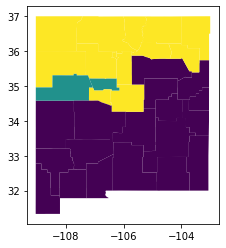

In [46]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }

# Now add the assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }

# pick a position u in the dataframe
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    
    # what node in G has this geoid?
    i = node_with_this_geoid[geoid]
    
    # position u in the dataframe should be given
    # the same district # that county i has in 'labeling'
    assignment[u] = labeling[i]
    
# now add the assignments to a column of our dataframe and then map it
df['assignment'] = assignment

my_fig = df.plot(column='assignment').get_figure()